# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [127]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [128]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [129]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [130]:
df_train_features.shape

(31698, 245)

In [131]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [132]:
df_train_features.dtypes

game_time                       int64
game_mode                       int64
lobby_type                      int64
objectives_len                  int64
chat_len                        int64
r1_hero_id                      int64
r1_kills                        int64
r1_deaths                       int64
r1_assists                      int64
r1_denies                       int64
r1_gold                         int64
r1_lh                           int64
r1_xp                           int64
r1_health                       int64
r1_max_health                   int64
r1_max_mana                   float64
r1_level                        int64
r1_x                            int64
r1_y                            int64
r1_stuns                      float64
r1_creeps_stacked               int64
r1_camps_stacked                int64
r1_rune_pickups                 int64
r1_firstblood_claimed           int64
r1_teamfight_participation    float64
r1_towers_killed                int64
r1_roshans_k

In [133]:
list(df_train_features.columns)

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [134]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [135]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [137]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 15.4 s, sys: 171 ms, total: 15.6 s
Wall time: 2.34 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [138]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [139]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [140]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [141]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [142]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 2.14 s, sys: 501 ms, total: 2.64 s
Wall time: 13.6 s


In [143]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [144]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [145]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [146]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [147]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [148]:
match

{'game_time': 2049,
 'match_id_hash': '75112757bde649d5cff1c7cd4f1275c6',
 'teamfights': [{'start': 306.755,
   'end': 338.551,
   'last_death': 323.454,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
     'item_uses': {},
     'killed': {'npc_dota_hero_faceless_void': 114},
     'deaths': 0,
     'buybacks': 0,
     'damage': 383,
     'healing': 0,
     'gold_delta': 336,
     'xp_delta': 440},
    {'deaths_pos': {},
     'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
     'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 458,
     'healing': 0,
     'gold_delta': -10,
     'xp_delta': 76},
    {'deaths_pos': {},
     'ability_uses': {},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
     'healing': 0,
     'gold_delta': 174,
     'xp_delta': 249},
    {'deaths_pos': {},
     'abilit

In [149]:
player

{'player_slot': 132,
 'hero_id': 83,
 'hero_name': 'npc_dota_hero_treant',
 'account_id_hash': '116aa09d7684da7a6bc388276b1abd1a',
 'ability_upgrades': [{'ability': 5434, 'time': 285, 'level': 1},
  {'ability': 5436, 'time': 488, 'level': 2},
  {'ability': 5436, 'time': 672, 'level': 3},
  {'ability': 5435, 'time': 913, 'level': 4},
  {'ability': 5437, 'time': 1144, 'level': 5},
  {'ability': 5436, 'time': 1145, 'level': 6},
  {'ability': 5436, 'time': 1360, 'level': 7},
  {'ability': 5435, 'time': 1527, 'level': 8},
  {'ability': 5435, 'time': 1660, 'level': 9},
  {'ability': 6024, 'time': 1687, 'level': 10},
  {'ability': 5435, 'time': 1916, 'level': 11}],
 'obs_placed': 8,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 17,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.217,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 8,
 'stuns': 33.337,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 2010.079,
  'max': True,
  'inflict

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [150]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

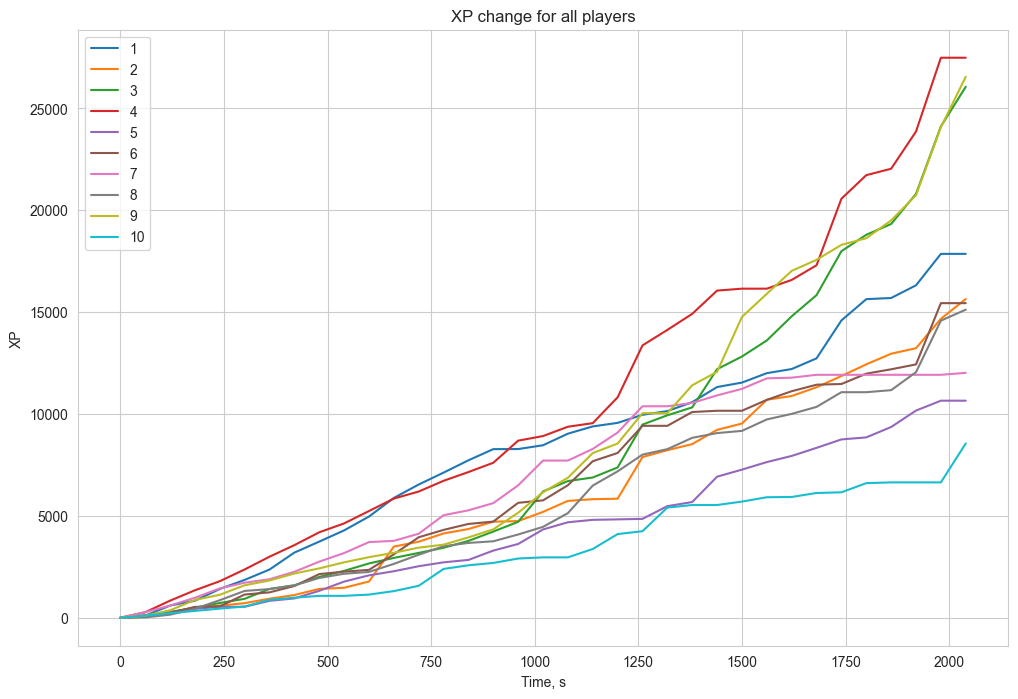

In [151]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [152]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Узнаем размер карты

In [153]:
map_size = df_train_features['r1_x'].max()

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [154]:
import numpy as np


def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash,
                        "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash,
                        "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # Составы команд как списки?
        

        # Посчитаем расстояние от каждого игрока до важных точек на карте
        important_points = [np.array((i * map_size / 2, j * map_size / 2))
                            for i in range(0, 3) for j in range(0, 3)]

        for player_id, player in enumerate(match["players"]):
            x = player['x']
            y = player['y']
            player_position = np.array((x, y))
            for i, important_position in enumerate(important_points):
                distance = np.linalg.norm(player_position - important_position)
                df_features.loc[match_id_hash,
                                f"distance_{player_id}_{i}"] = distance

        # Посчитаем среднее количество нанесённого и полученного урона
        def get_damage(player):
            damage = 0
            for person, amount in player["damage"].items():
                damage += amount
            return damage
        
        def get_damage_taken(player):
            damage = 0
            for person, amount in player["damage"].items():
                damage += amount
            return damage

        # После просмотра важности фичей, стало понятно что надо считать дифф
        players = match["players"]

        teams = {
            'r': players[0:5],
            'd': players[5:10]
        }

        diff = 0
        for team, team_players in teams.items():
            damage = 0
            for i, player in enumerate(team_players):
                p_damage = get_damage(player)
                damage += p_damage
                # df_features.loc[match_id_hash, f"{team}{i + 1}_damage"] = p_damage
            diff = diff - damage
            df_features.loc[match_id_hash, f"{team}_damage"] = damage
        
        df_features.loc[match_id_hash, f"diff_damage"] = diff
       
        diff = 0
        for team, team_players in teams.items():
            damage = 0
            for i, player in enumerate(team_players):
                p_damage = get_damage_taken(player)
                damage += p_damage
                # df_features.loc[match_id_hash, f"{team}{i + 1}_damage_taken"] = p_damage
            diff = diff - damage
            df_features.loc[match_id_hash, f"{team}_damage_taken"] = damage
        
        df_features.loc[match_id_hash, f"diff_damage_taken"] = diff

        match_features = df_features.loc[match_id_hash]

        for param in ['kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'health', 'max_health', 'max_mana', 'level']:
            diff = 0
            for team in ['r', 'd']:
                value_metric = 0
                for i in range(1, 6):
                    value_metric += match_features[f'{team}{i}_{param}']
                df_features.loc[match_id_hash, f'{team}_{param}'] = value_metric
                diff = diff - value_metric
            df_features.loc[match_id_hash, f'diff_{param}'] = diff
        
        # Достанем pred_vict
        for param in ['pred_vict', 'obs_placed', 'sen_placed']:
            for team, team_players in teams.items():
                damage = 0
                for i, player in enumerate(team_players):
                    df_features.loc[match_id_hash, f"{team}{i + 1}_{param}"] = player[f'{param}']

        teamfights = match['teamfights']
        # Посчитаем время последней смерти
        last_death = [0 for i in range(10)]
        for teamfight in teamfights:
            timer = teamfight['last_death']
            for i, player in enumerate(teamfight['players']):
                if player['deaths'] > 0:
                    last_death[i] = timer

        for i, timer in enumerate(last_death):
            team = 'r' if (i < 5) else 'd'
            df_features.loc[match_id_hash, f"{team}{i % 5 + 1}_last_death"] = match['game_time'] - timer



In [155]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [156]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r1_last_death,r2_last_death,r3_last_death,r4_last_death,r5_last_death,d1_last_death,d2_last_death,d3_last_death,d4_last_death,d5_last_death
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,658.0,658.0,658.0,658.0,658.0,658.0,658.0,658.0,658.0,658.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0,160.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,1016.0,1016.0,1016.0,1016.0,1016.0,1016.0,1016.0,1016.0,1016.0,1016.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,582.0,582.0,582.0,582.0,582.0,582.0,582.0,582.0,582.0,582.0


In [157]:
%pip install catboost


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [159]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 1.15 s, sys: 303 ms, total: 1.46 s
Wall time: 32.1 s


In [160]:
parameters_by_importance = ['diff_tower_kills', 'r_denies', 'd_health', 'd_denies', 'd1_hero_id', 'd2_hero_id', 'r_health', 'd_kills', 'r3_hero_id', 'r2_hero_id', 'd5_hero_id', 'd_deaths', 'r5_hero_id', 'd3_hero_id', 'r1_hero_id', 'r_deaths', 'd4_hero_id', 'r_kills', 'r4_hero_id', 'r_max_health', 'r_gold', 'd1_lh', 'd_gold', 'd3_lh', 'd3_health', 'd2_lh', 'r5_health', 'd4_health', 'distance_6_0', 'distance_5_8', 'distance_2_8', 'r4_teamfight_participation', 'd4_xp', 'distance_1_8', 'd1_health', 'r5_deaths', 'r2_teamfight_participation', 'distance_7_4', 'r3_lh', 'distance_7_0', 'distance_2_0', 'distance_8_0', 'r2_health', 'd_max_health', 'r4_health', 'd1_gold', 'r_xp', 'distance_7_8', 'distance_3_0', 'distance_0_8', 'r1_health', 'r2_lh', 'r3_health', 'distance_3_6', 'd2_deaths', 'r4_max_health', 'distance_4_8', 'd1_teamfight_participation', 'd_xp', 'distance_3_8', 'r1_teamfight_participation', 'd3_max_mana', 'distance_2_4', 'd2_denies', 'distance_0_3', 'distance_5_3', 'distance_6_8', 'r4_deaths', 'd3_teamfight_participation', 'distance_4_0', 'radiant_tower_kills', 'distance_9_8', 'distance_0_0', 'r3_teamfight_participation', 'distance_2_3', 'distance_5_0', 'd4_deaths', 'distance_8_8', 'r4_lh', 'r1_max_mana', 'r5_max_health', 'distance_9_0', 'd2_xp', 'distance_0_5', 'r1_deaths', 'r5_max_mana', 'distance_2_7', 'd2_teamfight_participation', 'd_assists', 'distance_4_3', 'distance_7_3', 'r5_teamfight_participation', 'distance_8_7', 'r3_gold', 'd4_lh', 'distance_9_3', 'distance_9_4', 'd2_health', 'distance_1_4', 'distance_8_3', 'd5_health', 'r2_denies', 'r5_lh', 'd5_deaths', 'distance_6_7', 'distance_3_4', 'distance_7_7', 'distance_1_0', 'd5_lh', 'distance_8_4', 'distance_3_3', 'r_assists', 'distance_9_5', 'distance_1_3', 'distance_1_5', 'd4_teamfight_participation', 'd5_teamfight_participation', 'distance_7_5', 'distance_5_4', 'r1_lh', 'r_level', 'd3_xp', 'distance_5_5', 'distance_5_7', 'distance_6_4', 'distance_4_1', 'r2_rune_pickups', 'd2_max_health', 'r3_max_mana', 'distance_4_4', 'distance_5_2', 'distance_4_6', 'r4_max_mana', 'r1_denies', 'distance_0_7', 'd5_max_health', 'distance_6_3', 'distance_8_2', 'd1_rune_pickups', 'd1_max_health', 'distance_3_1', 'd1_stuns', 'd1_max_mana', 'd3_assists', 'r_damage', 'd4_max_mana', 'distance_4_7', 'd5_gold', 'd_damage', 'distance_0_4', 'distance_1_6', 'distance_8_5', 'distance_2_6', 'r3_rune_pickups', 'distance_7_6', 'd2_rune_pickups', 'distance_4_5', 'd3_gold', 'r_damage_taken', 'distance_7_2', 'distance_3_5', 'd4_kills', 'distance_4_2', 'r3_max_health', 'distance_1_1', 'r4_denies', 'r1_gold', 'distance_6_1', 'r4_xp', 'distance_6_2', 'r3_xp', 'distance_5_6', 'd3_deaths', 'r4_kills', 'd5_max_mana', 'd3_max_health', 'd2_max_mana', 'r2_max_health', 'distance_6_5', 'distance_5_1', 'distance_7_1', 'distance_6_6', 'r1_rune_pickups', 'distance_9_6', 'd3_denies', 'distance_3_7', 'd2_stuns', 'distance_1_7', 'd3_stuns', 'r4_gold', 'd4_denies', 'd5_denies', 'd4_gold', 'r_max_mana', 'r2_assists', 'r2_xp', 'r5_gold', 'distance_8_6', 'd4_max_health', 'r3_deaths', 'distance_8_1',
                            'distance_2_1', 'd1_denies', 'd_level', 'r1_stuns', 'r4_rune_pickups', 'r1_xp', 'd_damage_taken', 'distance_2_5', 'd1_xp', 'distance_9_2', 'r2_gold', 'r3_denies', 'distance_2_2', 'd5_xp', 'distance_3_2', 'r2_kills', 'r5_assists', 'r1_max_health', 'distance_0_6', 'r2_deaths', 'd2_gold', 'r5_denies', 'd4_y', 'distance_0_2', 'r3_kills', 'distance_9_7', 'r2_max_mana', 'distance_1_2', 'r2_y', 'distance_0_1', 'r5_stuns', 'r1_y', 'distance_9_1', 'd4_stuns', 'r3_stuns', 'r3_assists', 'd5_kills', 'r2_stuns', 'r4_x', 'chat_len', 'd_max_mana', 'd4_x', 'd3_y', 'r3_y', 'r4_stuns', 'd2_y', 'r5_y', 'dire_tower_kills', 'd1_deaths', 'objectives_len', 'r5_xp', 'r1_assists', 'd3_x', 'd5_rune_pickups', 'd5_assists', 'r4_y', 'd2_assists', 'r5_x', 'r1_x', 'd1_x', 'd1_y', 'diff_health', 'diff_denies', 'd5_y', 'r3_x', 'r5_rune_pickups', 'd3_level', 'd1_last_death', 'd2_x', 'd4_assists', 'd4_level', 'd5_stuns', 'd3_rune_pickups', 'd2_kills', 'r1_level', 'r2_x', 'd4_rune_pickups', 'r1_last_death', 'd3_last_death', 'd4_obs_placed', 'd3_kills', 'd5_last_death', 'r3_last_death', 'd4_last_death', 'r2_last_death', 'd5_x', 'r4_assists', 'r2_creeps_stacked', 'r4_firstblood_claimed', 'd1_kills', 'r1_kills', 'd1_assists', 'd2_creeps_stacked', 'r5_kills', 'r4_level', 'r5_obs_placed', 'd1_obs_placed', 'r5_level', 'd3_creeps_stacked', 'd1_creeps_stacked', 'd2_level', 'diff_max_mana', 'd2_last_death', 'r2_level', 'diff_max_health', 'r3_creeps_stacked', 'r5_last_death', 'r2_sen_placed', 'd4_creeps_stacked', 'd5_creeps_stacked', 'r3_level', 'r5_sen_placed', 'd2_obs_placed', 'r2_firstblood_claimed', 'r1_pred_vict', 'd2_sen_placed', 'r3_obs_placed', 'd3_obs_placed', 'r4_obs_placed', 'r2_obs_placed', 'd1_level', 'diff_assists', 'diff_deaths', 'r1_obs_placed', 'game_mode', 'r5_creeps_stacked', 'r2_camps_stacked', 'diff_damage_taken', 'r4_last_death', 'r5_firstblood_claimed', 'd5_obs_placed', 'd5_sen_placed', 'diff_level', 'r5_towers_killed', 'diff_damage', 'diff_xp', 'r1_sen_placed', 'd5_camps_stacked', 'r3_sen_placed', 'r4_creeps_stacked', 'r3_camps_stacked', 'd4_sen_placed', 'd1_sen_placed', 'd4_camps_stacked', 'game_time', 'd5_level', 'diff_kills', 'r3_towers_killed', 'd4_firstblood_claimed', 'r4_sen_placed', 'r1_firstblood_claimed', 'diff_gold', 'r4_towers_killed', 'd4_pred_vict', 'd2_camps_stacked', 'r5_camps_stacked', 'd1_camps_stacked', 'd1_towers_killed', 'd5_towers_killed', 'd3_sen_placed', 'd1_roshans_killed', 'r2_towers_killed', 'd3_camps_stacked', 'r1_camps_stacked', 'lobby_type', 'r1_towers_killed', 'd1_pred_vict', 'r1_creeps_stacked', 'd3_towers_killed', 'd5_pred_vict', 'r4_roshans_killed', 'd1_firstblood_claimed', 'r5_pred_vict', 'r4_camps_stacked', 'r4_pred_vict', 'd2_pred_vict', 'd2_firstblood_claimed', 'r3_roshans_killed', 'd3_roshans_killed', 'd5_roshans_killed', 'r1_roshans_killed', 'd4_towers_killed', 'd2_towers_killed', 'd5_firstblood_claimed', 'd3_firstblood_claimed', 'd3_pred_vict', 'r2_pred_vict', 'd2_roshans_killed', 'r2_roshans_killed', 'r3_firstblood_claimed', 'r5_roshans_killed', 'd4_roshans_killed', 'r3_pred_vict']


In [161]:
parameters_by_importance[380:]

['d5_roshans_killed',
 'r1_roshans_killed',
 'd4_towers_killed',
 'd2_towers_killed',
 'd5_firstblood_claimed',
 'd3_firstblood_claimed',
 'd3_pred_vict',
 'r2_pred_vict',
 'd2_roshans_killed',
 'r2_roshans_killed',
 'r3_firstblood_claimed',
 'r5_roshans_killed',
 'd4_roshans_killed',
 'r3_pred_vict']

In [162]:
%%time
from catboost import CatBoostClassifier

cat_features_suffix = ['hero_id', 'pred_vict']

cat_features = ['game_mode', 'lobby_type'] + \
    [f'{team}{i}_{suffix}' for suffix in cat_features_suffix
     for team in ['r', 'd']
     for i in range(1, 6)]


catboost_model = CatBoostClassifier(cat_features=cat_features,
                                    ignored_features=parameters_by_importance[50:],
                                    iterations=5000,
                                    random_seed=SEED,
                                    verbose=True)

CPU times: user 54 µs, sys: 209 µs, total: 263 µs
Wall time: 266 µs


In [167]:
%%time

df_train_features_extended[cat_features] = df_train_features_extended[cat_features].apply(lambda x: pd.Categorical(x))
cv_scores_catboost = cross_val_score(catboost_model, df_train_features_extended, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Learning rate set to 0.008846
Learning rate set to 0.008846
Learning rate set to 0.008846
Learning rate set to 0.008846
Learning rate set to 0.008846
0:	learn: 0.6909037	total: 91.4ms	remaining: 7m 36s
0:	learn: 0.6909652	total: 91.5ms	remaining: 7m 37s
0:	learn: 0.6910220	total: 97.6ms	remaining: 8m 7s
0:	learn: 0.6908783	total: 102ms	remaining: 8m 30s
1:	learn: 0.6889507	total: 148ms	remaining: 6m 9s
0:	learn: 0.6909284	total: 144ms	remaining: 12m 2s
1:	learn: 0.6888377	total: 157ms	remaining: 6m 32s
1:	learn: 0.6889410	total: 176ms	remaining: 7m 20s
2:	learn: 0.6869247	total: 203ms	remaining: 5m 37s
1:	learn: 0.6887861	total: 217ms	remaining: 9m 2s
2:	learn: 0.6867495	total: 238ms	remaining: 6m 36s
2:	learn: 0.6869453	total: 239ms	remaining: 6m 38s
3:	learn: 0.6849167	total: 278ms	remaining: 5m 46s
3:	learn: 0.6847830	total: 295ms	remaining: 6m 7s
3:	learn: 0.6850507	total: 295ms	remaining: 6m 7s
1:	learn: 0.6888394	total: 329ms	remaining: 13m 42s
2:	learn: 0.6865906	total: 329ms	re

In [170]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(random_state=SEED)

In [171]:
%%time

cv_scores_mlp = cross_val_score(mlp_model, df_train_features_extended, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 33.9 ms, sys: 73.7 ms, total: 108 ms
Wall time: 8 s


In [172]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")
print(f"ROC-AUC на catboost: {cv_scores_catboost.mean()}")
print(f"ROC-AUC на MLP: {cv_scores_mlp.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7681567063793017
ROC-AUC на catboost: 0.8101835873769725
ROC-AUC на MLP: 0.7187661336063694


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## <left>Посылка

In [173]:
catboost_model.fit(df_train_features_extended, y)

Learning rate set to 0.010302
0:	learn: 0.6904090	total: 24.6ms	remaining: 2m 3s
1:	learn: 0.6880806	total: 42.2ms	remaining: 1m 45s
2:	learn: 0.6857463	total: 62.3ms	remaining: 1m 43s
3:	learn: 0.6833990	total: 84.9ms	remaining: 1m 46s
4:	learn: 0.6811088	total: 108ms	remaining: 1m 47s
5:	learn: 0.6788528	total: 129ms	remaining: 1m 47s
6:	learn: 0.6766887	total: 149ms	remaining: 1m 46s
7:	learn: 0.6746760	total: 165ms	remaining: 1m 43s
8:	learn: 0.6724724	total: 182ms	remaining: 1m 40s
9:	learn: 0.6705126	total: 199ms	remaining: 1m 39s
10:	learn: 0.6684345	total: 216ms	remaining: 1m 37s
11:	learn: 0.6665006	total: 235ms	remaining: 1m 37s
12:	learn: 0.6646154	total: 257ms	remaining: 1m 38s
13:	learn: 0.6625739	total: 278ms	remaining: 1m 39s
14:	learn: 0.6607087	total: 297ms	remaining: 1m 38s
15:	learn: 0.6589132	total: 319ms	remaining: 1m 39s
16:	learn: 0.6570116	total: 336ms	remaining: 1m 38s
17:	learn: 0.6552818	total: 357ms	remaining: 1m 38s
18:	learn: 0.6535955	total: 377ms	remaini

In [174]:
catboost_model.get_metadata()

In [175]:
df_train_features_extended.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'r1_last_death', 'r2_last_death', 'r3_last_death', 'r4_last_death',
       'r5_last_death', 'd1_last_death', 'd2_last_death', 'd3_last_death',
       'd4_last_death', 'd5_last_death'],
      dtype='object', length=394)

In [176]:
pd.set_option('display.max_rows', None)
print(catboost_model.get_feature_importance(prettified=True)['Feature Id'].tolist())

['diff_tower_kills', 'd_gold', 'r_gold', 'r_xp', 'r_deaths', 'r_kills', 'd_kills', 'd_deaths', 'r_denies', 'd_health', 'r_health', 'd_denies', 'd2_hero_id', 'd1_hero_id', 'distance_0_8', 'd4_xp', 'd3_hero_id', 'distance_1_8', 'r5_hero_id', 'r_max_health', 'r3_hero_id', 'distance_6_0', 'distance_3_0', 'd2_lh', 'r1_hero_id', 'r2_hero_id', 'distance_5_8', 'distance_8_0', 'd_max_health', 'd5_hero_id', 'd4_hero_id', 'r4_teamfight_participation', 'distance_2_8', 'd1_gold', 'd3_lh', 'distance_2_0', 'r3_lh', 'r4_hero_id', 'd1_lh', 'distance_7_8', 'distance_7_0', 'r2_teamfight_participation', 'distance_7_4', 'r5_health', 'd3_health', 'd1_health', 'r2_health', 'r4_health', 'd4_health', 'r5_deaths', 'game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_fi

In [177]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

# Скопируем таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [179]:
df_test_features_extended[cat_features] = df_test_features_extended[cat_features].apply(lambda x: pd.Categorical(x))
X_test = df_test_features_extended
y_test_pred = catboost_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features_extended.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-10_01-35-00.csv


### Итого:
Сначала я попробовала использовать catboost вместо дефолтного дерева, и сразу повысила скор до 0.8. Далее происходил дикий feature engineering, и там скор то повышался, то понижался, в итоге я отранжировала фичи по важности и сделала так, чтобы скор был повыше. Далее я попробовала one hot encoding для категориальных признаков, скор упал. Потом я пробоавала регулировать learning rate, но оказалось, что catboost сам примерно оптимальный ищет. Потом по приколу запустила простейшую нейронку, результат у нее был сильно хуже, но если бы мне было не влом нормально ее обучить, то она явно большой скор получила бы.